# Part-G


In [54]:
# load the data, take random 100 samples from the validation
import pickle

label2idx = {
    "bug_report": 1,
    "improvement_request": 2,
    "rating": 3,
    "others": 4,
}
idx2label = {value: key for key, value in label2idx.items()}
# read the train/test data
with open("Data/multilabel_train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

# split into 85% train/ 15% validation
import numpy as np
from sklearn.model_selection import train_test_split

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=777
)
# Take 100 random samples from validation set
random_indices = np.random.choice(len(X_val), size=100, replace=False)
X_val_sample = [X_val[i] for i in random_indices]
y_val_sample = y_val[random_indices]
print(X_val_sample[1])
print(y_val_sample[1])

لعبه رائعه وسريعه
[0 0 1 0]


In [10]:
from langchain.chat_models import ChatOpenAI

# Define the OpenAI API key and model arguments
from langchain.schema import HumanMessage

llm = ChatOpenAI(
    openai_api_key=KEY,
    model="gpt-3.5-turbo",
    temperature=0,
    max_tokens=100,
)


/tmp/ipykernel_1919/3167523967.py:8: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


#  **Zero-shot Classification**


# English prompting

In [19]:
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from pydantic import BaseModel, Field
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser


In [26]:
class ResponseFormatter(BaseModel):
    bug_report: int = Field(description="1 if review reports bugs/errors, 0 otherwise")
    improvement_request: int = Field(description="1 if review requests new features/improvements, 0 otherwise")
    rating: int = Field(description="1 if review contains opinions about the app, 0 otherwise")
    others: int = Field(description="1 if review is spam/irrelevant/uncategorizable, 0 otherwise")

parser = PydanticOutputParser(pydantic_object=ResponseFormatter)
format_instructions = parser.get_format_instructions()

In [60]:
prompt_template=r"""
You are an expert app review classifier. Your task is to analyze a user's app review and output a JSON object indicating which categories the review belongs to.
Use the following keys with values 0 or 1, where 1 means the review falls into that category and 0 means it does not:

{{
    "bug_report": 1,          # Reporting issues like bugs or errors
    "improvement_request": 0,  # Requests for new features or improvements
    "rating": 1,              # Positive or negative opinions on the app
    "others": 0               # Spam, irrelevant, or uncategorizable reviews
}}

Please analyze the following review and return only the JSON object as shown above, without any additional text or explanation.

Review: {text}
JSON:
"""
zero_shot_prompt_en = PromptTemplate(
    input_variables=["text"],
    template=prompt_template,
)
chain = LLMChain(llm=llm, prompt=zero_shot_prompt_en)

In [61]:
prompt_template_bonus=r"""
You are an expert app review classifier. Your task is to analyze a user's app review and output a JSON object indicating which categories the review belongs to.
Use the following keys with values 0 or 1, where 1 means the review falls into that category and 0 means it does not:

{{
    "bug_report": 1,          # Reporting issues like bugs or errors
    "improvement_request": 0,  # Requests for new features or improvements
    "rating": 1,              # Positive or negative opinions on the app
    "others": 0               # Spam, irrelevant, or uncategorizable reviews
}}

Please analyze the following review and return only the JSON object as shown above, without any additional text or explanation.

Review: {text}
JSON:
Let's think step by step:
"""
zero_shot_prompt_en_bonus = PromptTemplate(
    input_variables=["text"],
    template=prompt_template_bonus,
)
chain_bonus = LLMChain(llm=llm, prompt=zero_shot_prompt_en_bonus)

In [30]:
review = "The app crashes every time I try to upload a file. Please fix it!"
raw_output = chain.run(text=review)
print("Raw model output:", raw_output)
structured_res = parser.parse(raw_output)
print("Structured prediction:", structured_res.json())

Raw model output: {
    "bug_report": 1,
    "improvement_request": 0,
    "rating": 1,
    "others": 0
}
Structured prediction: {"bug_report":1,"improvement_request":0,"rating":1,"others":0}


/tmp/ipykernel_1919/1844307504.py:10: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  print("Structured prediction:", structured_res.json())


### **Get Model's Predictions**


In [62]:
from tqdm import tqdm
val_predictions = []
for review_text in tqdm(X_val_sample, desc="Classifying reviews"):
    raw = chain.run(text=review_text)
    res = parser.parse(raw)
    val_predictions.append([
        res.bug_report,
        res.improvement_request,
        res.rating,
        res.others,
    ])

val_array = np.array(val_predictions)
print(f"Batch predictions shape: {val_array.shape}")

Classifying reviews: 100%|████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]

Batch predictions shape: (100, 4)


In [63]:
from tqdm import tqdm
val_predictions_bonus = []
for review_text in tqdm(X_val_sample, desc="Classifying reviews"):
    raw = chain_bonus.run(text=review_text)
    res = parser.parse(raw)
    val_predictions_bonus.append([
        res.bug_report,
        res.improvement_request,
        res.rating,
        res.others,
    ])

val_array_bonus = np.array(val_predictions)
print(f"Batch predictions shape: {val_array_bonus.shape}")

Classifying reviews: 100%|████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]

Batch predictions shape: (100, 4)


### **Model Evaluation**


In [64]:
from sklearn.metrics import classification_report, confusion_matrix

print(f"evaluated {len(val_array)} reviews")

print("Test Classification Report:")
print(
    classification_report(
        y_val_sample,
        val_array,
        target_names=["bug_report", "improvement_request", "rating", "others"],
        zero_division=0,
    )
)
print("-" * 50)

print("Test Confusion Matrix:")
# calculate confusion matrix for each class
for i, class_name in enumerate(
    ["bug_report", "improvement_request", "rating", "others"]
):
    print(f"\nConfusion Matrix for {class_name}:")
    y_true = [y[i] for y in y_val_sample]
    y_pred = [y[i] for y in val_array]
    print(confusion_matrix(y_true, y_pred))

evaluated 100 reviews
Test Classification Report:
                     precision    recall  f1-score   support

         bug_report       0.81      0.65      0.72        40
improvement_request       0.94      0.35      0.51        46
             rating       0.77      0.98      0.87        62
             others       1.00      0.12      0.22        32

          micro avg       0.81      0.59      0.69       180
          macro avg       0.88      0.53      0.58       180
       weighted avg       0.86      0.59      0.63       180
        samples avg       0.83      0.68      0.71       180

--------------------------------------------------
Test Confusion Matrix:

Confusion Matrix for bug_report:
[[54  6]
 [14 26]]

Confusion Matrix for improvement_request:
[[53  1]
 [30 16]]

Confusion Matrix for rating:
[[20 18]
 [ 1 61]]

Confusion Matrix for others:
[[68  0]
 [28  4]]


In [65]:
from sklearn.metrics import classification_report, confusion_matrix

print(f"evaluated {len(val_array)} reviews")

print("Test Classification Report:")
print(
    classification_report(
        y_val_sample,
        val_array_bonus,
        target_names=["bug_report", "improvement_request", "rating", "others"],
        zero_division=0,
    )
)
print("-" * 50)

print("Test Confusion Matrix:")
# calculate confusion matrix for each class
for i, class_name in enumerate(
    ["bug_report", "improvement_request", "rating", "others"]
):
    print(f"\nConfusion Matrix for {class_name}:")
    y_true = [y[i] for y in y_val_sample]
    y_pred = [y[i] for y in val_array_bonus]
    print(confusion_matrix(y_true, y_pred))

evaluated 100 reviews
Test Classification Report:
                     precision    recall  f1-score   support

         bug_report       0.81      0.65      0.72        40
improvement_request       0.94      0.35      0.51        46
             rating       0.77      0.98      0.87        62
             others       1.00      0.12      0.22        32

          micro avg       0.81      0.59      0.69       180
          macro avg       0.88      0.53      0.58       180
       weighted avg       0.86      0.59      0.63       180
        samples avg       0.83      0.68      0.71       180

--------------------------------------------------
Test Confusion Matrix:

Confusion Matrix for bug_report:
[[54  6]
 [14 26]]

Confusion Matrix for improvement_request:
[[53  1]
 [30 16]]

Confusion Matrix for rating:
[[20 18]
 [ 1 61]]

Confusion Matrix for others:
[[68  0]
 [28  4]]


# Few-shot Learning

In [46]:
def get_prompt(num_examples):
    input_vars = ["text"] + [f"example{i}" for i in range(1, num_examples + 1)]
    examples_block = "".join(
        f"Example{i}:\n{{example{i}}}\n\n" for i in range(1, num_examples + 1)
    )
    template = (
        "You are an expert app review classifier. Your task is to analyze a user's app review "
        "and output a JSON object indicating which categories the review belongs to.\n"
        "Use the following keys with values 0 or 1, where 1 means the review falls into that category "
        "and 0 means it does not:\n"
        "{{\n"
        '    "bug_report": 1,          # Reporting issues like bugs or errors\n'
        '    "improvement_request": 0,  # Requests for new features or improvements\n'
        '    "rating": 1,              # Positive or negative opinions on the app\n'
        '    "others": 0               # Spam, irrelevant, or uncategorizable reviews\n'
        "}}\n\n"
        f"{examples_block}"
        "Please analyze the following review and return only the JSON object as shown above, "
        "without any additional text or explanation.\n"
        "Review: {text}\n"
        "JSON: \n "
    )
    return PromptTemplate(input_variables=input_vars, template=template)


In [52]:
# Prepare one-shot example from first validation sample
one_shot_chain = LLMChain(llm=llm, prompt=get_prompt(1))

example_labels = y_val_sample[0]
label_dict = {
    "bug_report": int(example_labels[0]),
    "improvement_request": int(example_labels[1]),
    "rating": int(example_labels[2]),
    "others": int(example_labels[3]),
}
example1 = f"Review: {X_val_sample[0]}\nJSON:{json.dumps(label_dict)}"
raw = one_shot_chain.run(text=review_text, example1=example1)
parsed = parser.parse(raw)
print(parsed)

bug_report=1 improvement_request=0 rating=0 others=0


In [111]:
# Take random samples from x_train and y_train to use as few-shot examples
shots = [1, 2, 3]
results = [(i, None) for i in shots]

indices = np.random.choice(len(X_train), size=max(shots), replace=False)
example_reviews = X_train[indices]
example_categories = y_train[indices]

# Get predictions and evaluate

In [114]:
from tqdm import tqdm

# Loop through different numbers of few-shot examples
for num_ex in [1, 2, 3]:
    # Get the few-shot prompt for current number of examples
    few_shot_prompt = get_prompt(num_ex)

    # Create prompt with examples
    prompt_args = {"text": ""}
    for i in range(num_ex):
        prompt_args[f"example{i+1}"] = (
            f"Review: {example_reviews[i]}\n JSON:{json.dumps({k:int(v) for k,v in zip(label2idx.keys(), example_categories[i])})}"
        )

    val_predictions_few = []

    # Get predictions for validation set
    for i in tqdm(range(len(X_val_sample))):
        review_text = X_val_sample[i]
        prompt_args["text"] = review_text

        prediction = llm.invoke(few_shot_prompt.format(**prompt_args))
        val_predictions_few.append(
            [
                prediction.bug_report,
                prediction.improvement_request,
                prediction.rating,
                prediction.others,
            ]
        )

        # # rotate the API key every 15 requests
        # if (i + 1) % 15 == 0:
        #     current_key = (current_key + 1) % len(KEYS)
        #     llm = ChatGoogleGenerativeAI(google_api_key=KEYS[current_key], **args)

    # Store results for this number of examples
    results[num_ex - 1] = (num_ex, val_predictions_few)

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


In [55]:
shots = [1, 2, 3]
results = {}

indices = np.random.choice(len(X_train), size=max(shots), replace=False)
example_reviews   = [X_train[i] for i in indices]
example_categories = [y_train[i] for i in indices]

for num_ex in shots:
    print(f"\nRunning {num_ex}-shot inference…")
    # build a new chain with num_ex examples in the prompt
    few_shot_chain = LLMChain(llm=llm, prompt=get_prompt(num_ex))
    val_preds = []

    for rev in tqdm(X_val_sample, desc=f"{num_ex}-shot"):
        # assemble the prompt arguments
        args = {"text": rev}
        for i in range(num_ex):
            lbls = example_categories[i]
            label_dict = {
                "bug_report":           int(lbls[0]),
                "improvement_request":  int(lbls[1]),
                "rating":               int(lbls[2]),
                "others":               int(lbls[3]),
            }
            args[f"example{i+1}"] = (
                f"Review: {example_reviews[i]}\n"
                f"JSON:{json.dumps(label_dict)}"
            )

        # run and parse
        raw = few_shot_chain.run(**args)
        parsed = parser.parse(raw)
        val_preds.append([
            parsed.bug_report,
            parsed.improvement_request,
            parsed.rating,
            parsed.others,
        ])

    # store results as a NumPy array
    results[num_ex] = np.array(val_preds)
    print(f"{num_ex}-shot batch shape: {results[num_ex].shape}")


Running 1-shot inference…


1-shot: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


1-shot batch shape: (100, 4)

Running 2-shot inference…


2-shot: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


2-shot batch shape: (100, 4)

Running 3-shot inference…


3-shot: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]

3-shot batch shape: (100, 4)



Classification report for 1-shot
--------------------------------------------------
                     precision    recall  f1-score   support

         bug_report       0.96      0.65      0.78        40
improvement_request       0.71      0.65      0.68        46
             rating       0.89      0.87      0.88        62
             others       1.00      0.16      0.27        32

          micro avg       0.85      0.64      0.73       180
          macro avg       0.89      0.58      0.65       180
       weighted avg       0.88      0.64      0.70       180
        samples avg       0.88      0.72      0.76       180


Classification report for 2-shot
--------------------------------------------------
                     precision    recall  f1-score   support

         bug_report       0.96      0.68      0.79        40
improvement_request       0.85      0.61      0.71        46
             rating       0.87      0.74      0.80        62
             others       0.75   

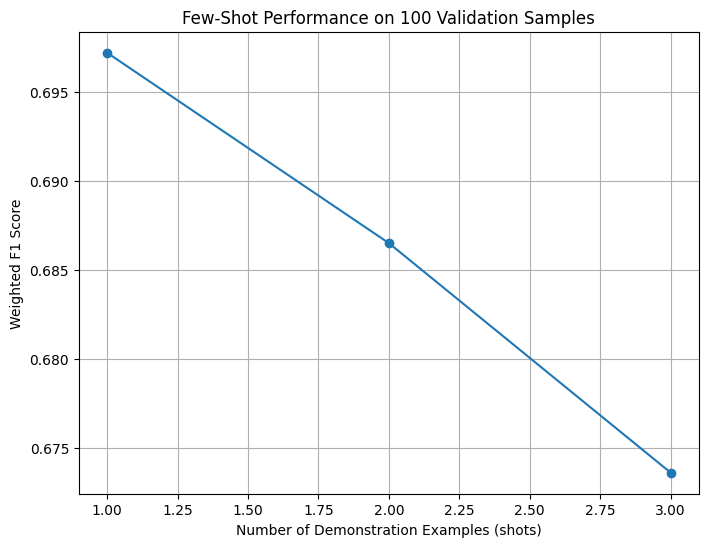

In [59]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Assuming `results` is a dict mapping shot counts to NumPy arrays of predictions,
# and `y_val_subset` holds the corresponding ground-truth labels for the 100 samples.

f1_scores = []
num_shots = []

for n, preds in results.items():
    num_shots.append(n)
    # Convert preds (shape [100, 4]) to list of lists for sklearn
    pred_list = preds.tolist()
    
    # Compute classification report
    report_dict = classification_report(
        y_val_sample,
        pred_list,
        target_names=["bug_report", "improvement_request", "rating", "others"],
        zero_division=0,
        output_dict=True
    )
    
    # Print detailed report
    print(f"\nClassification report for {n}-shot")
    print("-" * 50)
    print(classification_report(
        y_val_sample,
        pred_list,
        target_names=["bug_report", "improvement_request", "rating", "others"],
        zero_division=0
    ))
    
    # Collect weighted F1
    f1_scores.append(report_dict["weighted avg"]["f1-score"])

# Plot performance curve
plt.figure(figsize=(8, 6))
plt.plot(num_shots, f1_scores, marker="o")
plt.xlabel("Number of Demonstration Examples (shots)")
plt.ylabel("Weighted F1 Score")
plt.title("Few-Shot Performance on 100 Validation Samples")
plt.grid(True)
plt.show()
